In [1]:
import sys, os, glob, datetime, cftime,pickle
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd
from scipy import float64
from dill.source import getsource
import regionmask

from _decomp import *
from _print_and_plot import *
from linear_regression import get_slope_and_pval

%load_ext autoreload 
%autoreload 2

In [2]:
target_variable='TREFHT'
months=[6,7,8]
months_str = ','.join([str(m) for m in months])
tag = f"ERA5_{target_variable}_{'m'.join([str(m) for m in months])}"

In [56]:
period = [1979,2023]
y1,y2 = period

In [4]:
trend_dict = {}

In [36]:
oo = decomp_ERA5(target_variable=target_variable, months=months, period=period)
oo.target_open(0, 360, 30, 70, var_name_in_file='var167', cdo_options='-remapcon,r360x180')
tas_raw = oo._data_raw['target']
tas_raw = tas_raw.assign_coords(lon=(tas_raw.lon + 180) % 360 - 180)
tas_raw = tas_raw.assign_coords(lat=tas_raw.lat.round(3))
tas_raw = tas_raw.groupby(tas_raw.time.dt.year).mean()
tas_raw = tas_raw.loc[:,:60]
trend_dict[f"raw_{y1}-{y2}"] = get_slope_and_pval(tas_raw)

In [80]:
out_path = '/climca/people/ppfleiderer/decomposition/decomp_out'
y1,y2 = period
cc = decomp_ERA5(target_variable=target_variable, months=months, period=period)
cc.target_open(0, 360, 30, 70, var_name_in_file='var167', cdo_options='-remapcon,r360x180')
for component in ['circ','thermo']:
    tab = pd.read_csv(f'{out_path}/{tag}_stream_{y1}-{y2}/ERA5_predict_{component}.csv', index_col=0).sort_index()
    lat = np.unique(tab.lat.values)
    lon = np.unique(tab.lon.values)
    tas = xr.DataArray(
            tab.iloc[:,3:].values.reshape((len(lat),len(lon),-1)),
            dims=['lat','lon','time'],
            coords=dict(
                lat=lat, 
                lon=lon, 
                time=[datetime.datetime(int(t.split('-')[0]),int(t.split('-')[1]),int(t.split('-')[2])) for t in tab.columns[3:]]
                )
        )
    tas = tas.transpose('time','lat','lon')

    tas = tas.assign_coords(lon=(tas.lon + 180) % 360 - 180)
    tas = tas.assign_coords(year=tas.time.dt.year)
    tas = tas.assign_coords(lat=tas.lat.round(3))
    tas = tas.swap_dims({'time': 'year'})
    tas = tas.loc[y1:y2]#.roll(lon=144, roll_coords=True)
    tas = tas[np.isin(tas.time.dt.month,months)].loc[:,30:60]
    tas = tas.groupby('year').mean().load()
    trend_dict[f"ridge_{component}_{y1}-{y2}"] = get_slope_and_pval(tas)

In [37]:
data_path = '/climca/data/ETH2LIM/ETH2LIM/for_sebastian'
y1,y2 = period
reg = 'NH'

analog_in_file = f"/climca/data/ETH2LIM/ETH2LIM/for_sebastian/tasAdj_mon_ERA5_{reg}.nc"
nc = xr.open_dataset(analog_in_file)
nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
tas = nc['tas_dyn']
tas = tas[np.isin(tas.time.dt.month, months)]
tas = tas.loc[str(period[0]):str(period[1])]
tas = tas.groupby(tas.time.dt.year).mean()

slope__, p_value__ = get_slope_and_pval(tas)
slope = trend_dict[f"raw_{y1}-{y2}"][0].copy() * np.nan
slope[:] = slope__.sel(dict(lat=slope.lat, lon=slope.lon), method='nearest').values
p_value = trend_dict[f"raw_{y1}-{y2}"][0].copy() * np.nan
p_value[:] = p_value__.sel(dict(lat=p_value.lat, lon=p_value.lon), method='nearest').values
trend_dict[f'analog_circ_{y1}-{y2}'] = (slope, p_value)

slope__, p_value__ = get_slope_and_pval(tas_raw - tas)
slope = trend_dict[f"raw_{y1}-{y2}"][0].copy() * np.nan
slope[:] = slope__.sel(dict(lat=slope.lat, lon=slope.lon), method='nearest').values
p_value = trend_dict[f"raw_{y1}-{y2}"][0].copy() * np.nan
p_value[:] = p_value__.sel(dict(lat=p_value.lat, lon=p_value.lon), method='nearest').values
trend_dict[f'analog_thermo_{y1}-{y2}'] = (slope, p_value)

In [58]:
for component in ['circ','thermo']:
    y = xr.load_dataset(f'/climca/people/ppfleiderer/decomposition/DEA_homer/ERA5_trend_{y1}-{y2}_{component}.nc')
    y = y.sel(lat=slice(30,60))
    y = y.assign_coords(lon=(y.lon + 180) % 360 - 180)
    trend_dict[f"DEA_{component}_{y1}-{y2}"] = (y['slope'], y['pval'])

In [96]:
with xr.open_dataarray('/climca/data/ETH2LIM/CNRM2LIM/UNET_ERA5/UNET_ERA5_1979_2023.nc') as tas:
    tas = tas.assign_coords(lon=(tas.lon + 180) % 360 - 180)
    tas = tas.assign_coords(lat=tas.lat.round(3))
    tas = tas[np.isin(tas.time.dt.month, months)]
    tas = tas.groupby(tas.time.dt.year).mean()
    regridder = xe.Regridder(tas, tas_raw, method='bilinear')
    tas = regridder(tas)
    trend_dict[f'UNET_circ_{y1}-{y2}'] = get_slope_and_pval(tas)
    trend_dict[f'UNET_thermo_{y1}-{y2}'] = get_slope_and_pval(tas_raw - tas)

In [99]:
for name,y in trend_dict.items():
    mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(y[0].lon, y[0].lat)
    mask.values[np.isfinite(mask)] = 1
    slope = y[0] * mask
    p_value = y[1] * mask
    trend_dict[name] = (slope, p_value)

In [100]:
maxabs = 0.6
extent = [-180, 180, 30, 60]
levels = np.linspace(-maxabs,maxabs,31)

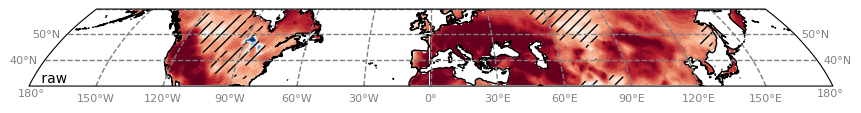

In [101]:
fig,ax = plt.subplots(nrows=1, figsize=(12,1), subplot_kw={'projection': cartopy.crs.Robinson()})
ax.set_extent(extent, crs=cartopy.crs.PlateCarree())
ax.coastlines()

xxx = trend_dict[f"raw_{y1}-{y2}"][0]
im = ax.contourf(xxx.lon, xxx.lat, xxx * 10, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')
xxx = trend_dict[f"raw_{y1}-{y2}"][1]
im2 = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), colors='none', hatches=['','///'], levels=[0,0.05,1])

ax.set_facecolor('w')
ax.annotate(f" raw", xy=(0.01,0.05), xycoords='axes fraction', fontsize=10)

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=1, linestyle='--')
gl.top_labels = False
gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,200,30,'int'))
gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(40,61,10,'int'))
gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}

savefig(f"ERA5_trend_map_raw_{y1}-{y2}")

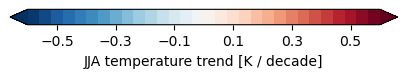

In [102]:
fig,ax = plt.subplots(figsize=(5, 0.2))
plt.colorbar(im, cax=ax, orientation='horizontal', label=f'JJA temperature trend [K / decade]', ticks=[-0.5, -0.3, -0.1, 0.1, 0.3, 0.5])
savefig(f"trend_maps_cbar_{maxabs}")

In [103]:
to_plot = {
    'ridge' : 'ridge',
    'analog' : 'analogues',
    'DEA' : 'DEA',
    'UNET' : 'UNET',
}

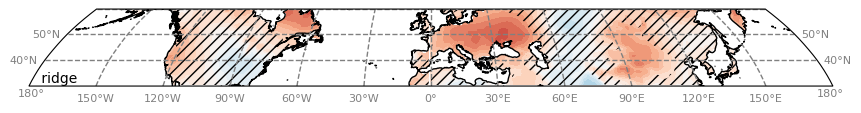

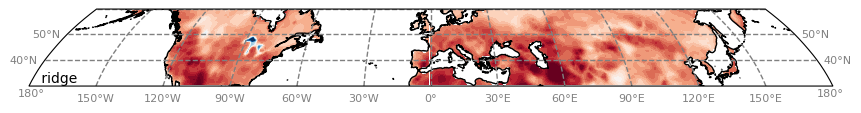

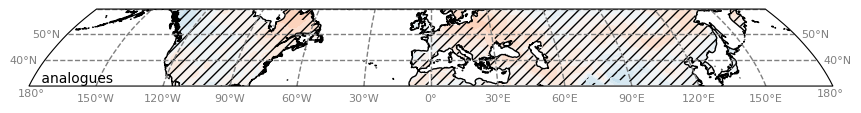

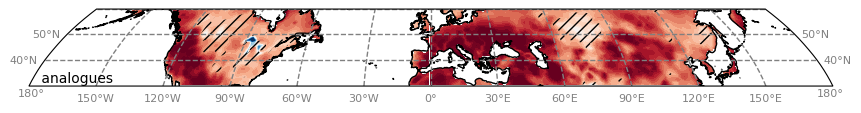

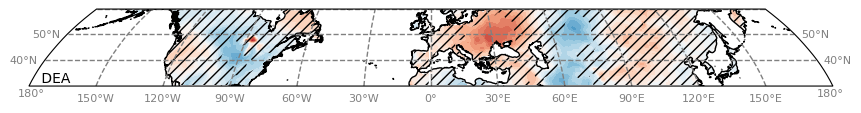

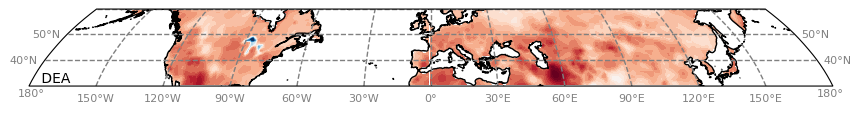

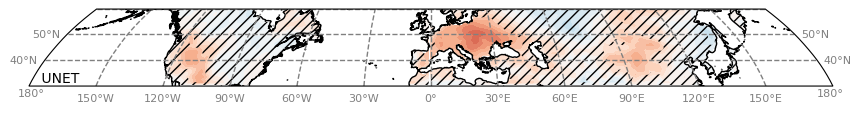

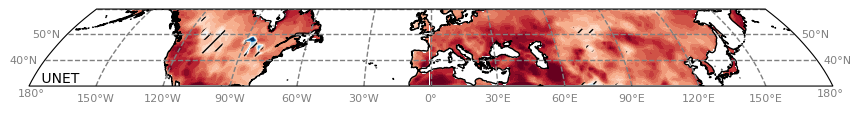

In [104]:
for name,long_name in to_plot.items():
    for component in ['circ','thermo']:

        fig,ax = plt.subplots(nrows=1, figsize=(12,1), subplot_kw={'projection': cartopy.crs.Robinson()})
        ax.set_extent(extent, crs=cartopy.crs.PlateCarree())
        ax.coastlines()
        xxx = trend_dict[f"{name}_{component}_{y1}-{y2}"][0]
        im = ax.contourf(xxx.lon, xxx.lat, xxx * 10, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')
        xxx = trend_dict[f"{name}_{component}_{y1}-{y2}"][1]
        im2 = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), colors='none', hatches=['','///'], levels=[0,0.05,1])

        gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                        linewidth=1, color='gray', alpha=1, linestyle='--')
        gl.top_labels = False
        gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,200,30,'int'))
        gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(40,61,10,'int'))
        gl.xlabel_style = {'size': 8, 'color': 'gray'}
        gl.ylabel_style = {'size': 8, 'color': 'gray'}

        ax.annotate(f" {long_name}", xy=(0.01,0.05), xycoords='axes fraction', fontsize=10)

        savefig(f"ERA5_trend_map_{name}_{component}_{y1}-{y2}")
